ref:
https://nbviewer.jupyter.org/github/blei-lab/edward/blob/master/notebooks/getting_started.ipynb

http://edwardlib.org/getting-started

****** for notation
http://edwardlib.org/api/inference

 Here we will show a Bayesian neural network. It is a neural network with a prior distribution on its weights.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
from edward.models import Normal,Empirical

plt.style.use('ggplot')

/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
# Getting needed data

def build_toy_dataset(N_points=50, noise_std=0.1):
    x = np.linspace(-3, 3, num=N_points)
    y = np.cos(x) + np.random.normal(0, noise_std, size=N_points)
    x = x.astype(np.float32).reshape((N_points, 1))
    y = y.astype(np.float32)
    return x, y

# simulate a toy dataset of observations with a cosine relationship.
N_points = 100  # number of data points

X_data,y_data = build_toy_dataset(N_points)

X_data = np.float32(X_data)
y_data = np.float32(y_data)

In [3]:
# Shuffling dataset
from sklearn.utils import shuffle

X_data_shuff,y_data_shuff = shuffle(X_data,y_data,random_state=23)
print (np.shape(X_data_shuff),np.shape(y_data_shuff))

(100, 1) (100,)


In [4]:
# Splitting dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data_shuff, y_data_shuff, test_size=0.2, random_state=23)
print (np.shape(X_train), np.shape(y_train))
print (np.shape(X_test), np.shape(y_test))

(80, 1) (80,)
(20, 1) (20,)


In [5]:
D = np.shape(X_train)[1]  # number of features or number of input neurons
H = 2
print (D,H) 

1 2


In [6]:
ed.set_seed(42)

Next, define a two-layer Bayesian neural network. Here, we define the neural network manually with `tanh` nonlinearities.

In [7]:
# Neural network number of neurons [D,H,1]
def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

# prior
W_0 = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
W_1 = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]))
b_0 = Normal(loc=tf.zeros(H), scale=tf.ones(H))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

#likelihood
X = tf.placeholder(tf.float32, [None, D], name="X")
y = Normal(loc=neural_network(X, W_0, W_1, b_0, b_1),
           scale=0.1 , name="y")

Next, make inferences about the model from data.

q's are random variables defined to approximate the posterior [http://edwardlib.org/api/inference]

In [8]:
# ref: https://github.com/blei-lab/edward/blob/master/examples/bayesian_logistic_regression.py
T = 6000 #Number of posterior samples
# INFERENCE
#ref:https://github.com/blei-lab/edward/blob/master/examples/bayesian_logistic_regression.py
qW_0 = Empirical(params=tf.get_variable("qW_0/params",[T,D,H]))
qW_1 = Empirical(params=tf.get_variable("qW_1/params",[T,H,1]))
qb_0 = Empirical(params=tf.get_variable("qb_0/params",[T,H]))
qb_1 = Empirical(params=tf.get_variable("qb_1/params",[T,1]))

Defining `tf.get_variable` allows the variational factors’ parameters to vary. They are initialized randomly.

In [9]:
# Sample functions from empirical model to visualize fits.
qW_0_s = qW_0.sample(1000)
qW_1_s = qW_1.sample(1000)
qb_0_s = qb_0.sample(1000)
qb_1_s = qb_1.sample(1000)
preds = tf.stack(
    [neural_network(X_data, qW_0_s[i], qW_1_s[i],
                    qb_0_s[i], qb_1_s[i])
     for i in range(1000)])

(1000, 100)
(100,)
(999, 100)


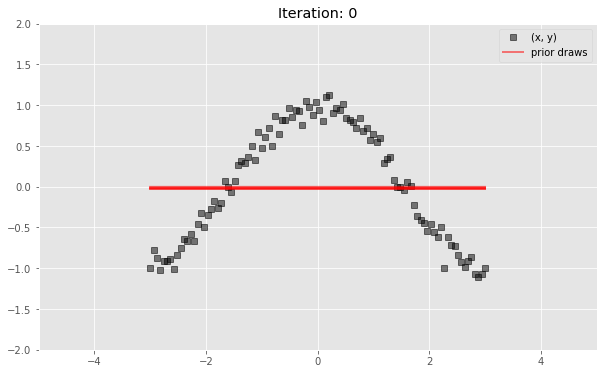

In [10]:
# FIRST VISUALIZATION (prior) #before optimization

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = preds.eval()

print(np.shape(outputs))
print(np.shape(outputs[0]))
print(np.shape(outputs[1:]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax.plot(X_data, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(X_data, outputs[1:5].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

Now, run HMC in order to infer the model’s latent variables given data.

In [11]:
inference = ed.HMC({W_0: qW_0, b_0: qb_0,W_1: qW_1, b_1: qb_1}, data={X: X_train, y: y_train})

inference.run(step_size=0.5/N_points, n_steps=10)

# #or

# inference.initialize(n_print=10, step_size=0.5/N_points, n_steps=10)
# tf.global_variables_initializer().run()
# for t in range(inference.n_iter):
#     info_dict = inference.update()
#     inference.print_progress(info_dict)

/Users/sharmila/anaconda3/envs/py36/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


6000/6000 [100%] ██████████████████████████████ Elapsed: 27s | Acceptance Rate: 0.953


In [12]:
print(inference.n_iter,inference.n_print,inference.n_steps)

6000 60 10


In [13]:
# print(help(inference))

In [14]:
## burning first few samples
burn = 1000
qW_0_params_b = qW_0.params.eval()[burn:,]
qW_1_params_b = qW_1.params.eval()[burn:,]
qb_0_params_b = qb_0.params.eval()[burn:,]
qb_1_params_b = qb_1.params.eval()[burn:,]
preds = tf.stack(
    [neural_network(X_data, qW_0_params_b[i], qW_1_params_b[i],
                   qb_0_params_b[i], qb_1_params_b[i])
     for i in range(1000)])

Finally, criticize the model fit. Bayesian neural networks define a distribution over neural networks, so we can perform a graphical check. Draw neural networks from the inferred model and visualize how well it fits the data.

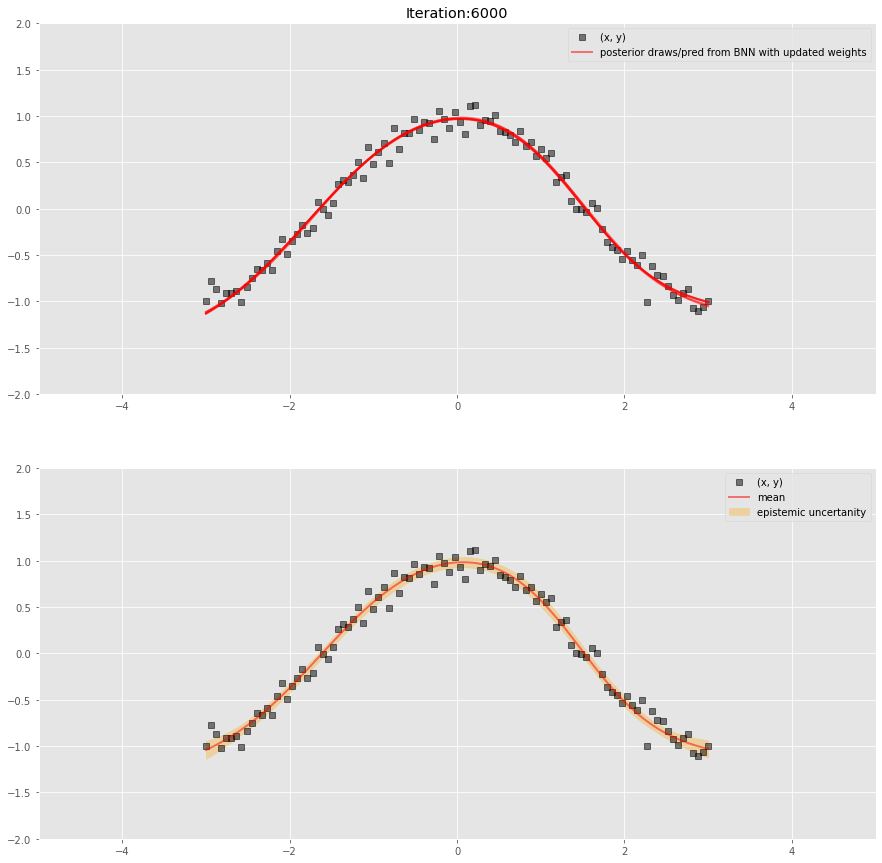

In [15]:
# SECOND VISUALIZATION (posterior) #after optimization

outputs = preds.eval()

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(211)
ax1.set_title("Iteration:"+str(inference.n_iter))
ax1.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax1.plot(X_data, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws/pred from BNN with updated weights')
ax1.plot(X_data, outputs[1:5].T, 'r', lw=2, alpha=0.5)
ax1.set_xlim([-5, 5])
ax1.set_ylim([-2, 2])
ax1.legend()


mean_pred = np.mean(outputs, axis=0)
std_pred = np.std(outputs, axis=0)
ax2 = fig.add_subplot(212)
ax2.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax2.plot( X_data, mean_pred , 'r', lw=2, alpha=0.5, label='mean')
ax2.fill_between( X_data.ravel(), mean_pred-2*std_pred, mean_pred+2*std_pred, alpha = 0.3, color = 'orange',label='epistemic uncertanity')
ax2.set_xlim([-5, 5])
ax2.set_ylim([-2, 2])
ax2.legend()

plt.show()

The model has captured the relationship between $x$ and $y$ in the observed domain.

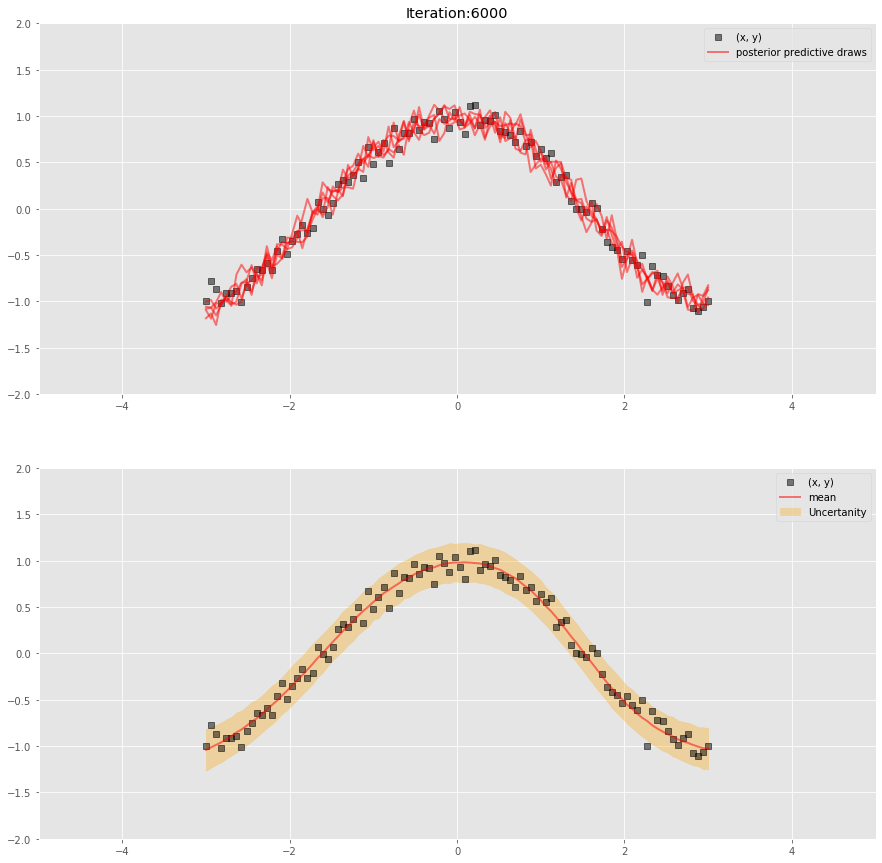

In [16]:
# THIRD VISUALIZATION (posterior predictive) 
preds_lik = tf.stack(
    [ Normal( loc=neural_network(X_data, qW_0_params_b[i], qW_1_params_b[i],
                   qb_0_params_b[i], qb_1_params_b[i]),scale=0.1 ).sample() 
     for i in range(1000)])
outputs_lik = preds_lik.eval()


fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(211)
ax1.set_title("Iteration:"+str(inference.n_iter))
ax1.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax1.plot(X_data, outputs_lik[0].T, 'r', lw=2, alpha=0.5, label='posterior predictive draws')
ax1.plot(X_data, outputs_lik[1:5].T, 'r', lw=2, alpha=0.5)
ax1.set_xlim([-5, 5])
ax1.set_ylim([-2, 2])
ax1.legend()

mean_pred_lik = np.mean(outputs_lik, axis=0)
std_pred_lik = np.std(outputs_lik, axis=0)
ax2 = fig.add_subplot(212)
ax2.plot(X_data, y_data, 'ks', alpha=0.5, label='(x, y)') # full data (train+test)
ax2.plot( X_data, mean_pred_lik , 'r', lw=2, alpha=0.5, label='mean')
ax2.fill_between( X_data.ravel(), mean_pred_lik-2*std_pred_lik, mean_pred_lik+2*std_pred_lik, alpha = 0.3, color = 'orange',label='Uncertanity')
ax2.set_xlim([-5, 5])
ax2.set_ylim([-2, 2])
ax2.legend()

plt.show()

         HMC    actual  error_HMC
0  -1.040755 -0.999480  -0.041275
1  -1.012711 -0.775236  -0.237475
2  -0.986212 -0.871301  -0.114911
3  -0.959261 -1.016748   0.057487
4  -0.924076 -0.913194  -0.010882
..       ...       ...        ...
95 -0.964379 -0.866508  -0.097871
96 -0.986738 -1.073581   0.086843
97 -1.004790 -1.104125   0.099336
98 -1.021827 -1.064329   0.042501
99 -1.025766 -0.997440  -0.028326

[100 rows x 3 columns]
RMSE for HMC predictions = 0.094


/Users/sharmila/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


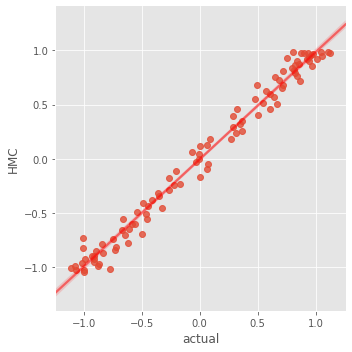

In [17]:
prediction_data = pd.DataFrame(
    {'HMC': mean_pred_lik.flatten(), 
     'actual': y_data.flatten(),
     'error_HMC': ( mean_pred_lik - y_data).flatten()})

print (prediction_data)

_ = sns.lmplot(y='HMC', x='actual', data=prediction_data,
               line_kws={'color': 'red', 'alpha': 0.5})

RMSE = np.sqrt(np.mean(prediction_data.error_HMC ** 2))
print(f'RMSE for HMC predictions = {RMSE:.3f}')

In [18]:
# print (y_post)
# print(W_0)

(1000, 1, 2)


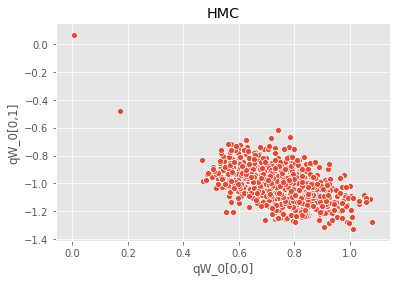

In [19]:
check = qW_0.sample(1000).eval()
print(check.shape)
param_samples_HMC = pd.DataFrame(
    {'qW_0[0,0]': check.reshape(check.shape[0],check.shape[2])[:,0], 
     'qW_0[0,1]': check.reshape(check.shape[0],check.shape[2])[:,1]})

_ = sns.scatterplot(x='qW_0[0,0]', y='qW_0[0,1]', data=param_samples_HMC).set_title('HMC')

In [20]:
print(qW_0)

RandomVariable("Empirical/", shape=(1, 2), dtype=float32)


In [21]:
print(qW_0.params.eval())
print(qW_0.params.eval().shape)
print(qW_0.params.eval()[0])
print(qW_0.params.eval()[0].shape)

[[[ 0.01125494  0.02128991]]

 [[ 0.00398882  0.06071505]]

 [[ 0.0239631   0.06580992]]

 ...

 [[ 0.72126985 -1.0387661 ]]

 [[ 0.72458327 -1.0256715 ]]

 [[ 0.7210039  -1.0648532 ]]]
(6000, 1, 2)
[[0.01125494 0.02128991]]
(1, 2)


In [22]:
print(qW_0.sample().eval())

[[ 0.93352735 -1.1580514 ]]


In [23]:
burn = 2
print(qW_0.params.eval()[burn:,].shape)
print(qW_0.params.eval()[burn:,])
print(qW_0.params.eval()[burn:,].mean())
print(qW_0.params.eval()[burn:,].mean(0))
print(qW_0.params.eval()[burn:,][0])

(5998, 1, 2)
[[[ 0.0239631   0.06580992]]

 [[ 0.04848916  0.0393221 ]]

 [[ 0.1162268   0.0179835 ]]

 ...

 [[ 0.72126985 -1.0387661 ]]

 [[ 0.72458327 -1.0256715 ]]

 [[ 0.7210039  -1.0648532 ]]]
-0.1257056
[[ 0.7516291 -1.0030378]]
[[0.0239631  0.06580992]]


In [24]:
print(qW_0_params_b)
print(qW_0_params_b.shape)
print(qW_0_params_b[0])
print(qW_0_params_b[0].shape)

[[[ 0.68204534 -0.9462899 ]]

 [[ 0.7070025  -0.938749  ]]

 [[ 0.7070025  -0.938749  ]]

 ...

 [[ 0.72126985 -1.0387661 ]]

 [[ 0.72458327 -1.0256715 ]]

 [[ 0.7210039  -1.0648532 ]]]
(5000, 1, 2)
[[ 0.68204534 -0.9462899 ]]
(1, 2)
